<a href="https://colab.research.google.com/github/MinghanChu/DeepLearning-ZerosToGans/blob/main/Data_Augmentation%2C_Regularization_%26_ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name='05b-cifar10-resnet'

In [3]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

100%|██████████| 135107811/135107811 [00:02<00:00, 59046405.38it/s]


['train', 'test']
['horse', 'automobile', 'bird', 'dog', 'deer', 'cat', 'frog', 'truck', 'airplane', 'ship']


**Training set, validation set, and test set**

1. The **training set** is the largest portion of the dataset. It is used to train the machine learning model. During training, the model learns the underlying patterns and relationships in the data by adjusting its parameters to minimize error. The error is based on the differences between the predicted output and the actual output (ground truth).  

2. **Validation set** is used during the training phase to evaluate the model's performance and to **tune hyperparameters** (parameters that are not learned directly within the model but are set before the training process).

  + **Prevent overfitting**: Overfitting occurs when a model learns the training data too well, including its noise and outliers, which negatively impacts its performance on new, unseen data. The validation set helps monitor this by providing an independent set of data that the model has not seen during training.

  + **Model selection**: By comparing the performance of different models or configurations on the validation set, we can choose the **best model architecture or set of hyperparameters**.

3. The test set is used to evaluate the final model's performance after the training and hyperparameter tuning processes are complete. This set is only used once to assess how well the **model generalizes to new, unseen data**. It provides an unbiased estimate of the model's real-world performance. The test set **should be kept separate and not used during the training or validation processes** to ensure an accurate measure of the model's predictive power.

**However, the following paragraph indicates that the test set is used as the validation set. **

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

## Preprocessing the data, e.g., normalization, crop, data augmentation

`torchvision.transforms` is a module in the `torchvision` library, which is a part of the `PyTorch` ecosystem. It provides a variety of common image transformations that are typically used in **preprocessing** images for computer vision tasks.

Note: Images need to be preprocessed (e.g., resized, normalized) before being fed into a neural network for training.

**Padding and dimension**

When you use a padding of 4 pixels on a 32x32 image, the padding is applied to all sides of the image. This means 4 pixels are added to the top, bottom, left, and right edges of the image. The total addition to both the height and the width of the image will be 8 pixels because padding is added to both sides.

Calculation
**Initial Size:**

+ Height: 32 pixels
+ Width: 32 pixels

Padding Applied:

**Padding of 4 pixels on each side:**

+ Top: +4 pixels
+ Bottom: +4 pixels
+ Left: +4 pixels
+ Right: +4 pixels

**Total Size After Padding:**

New Height = Original Height + Top Padding + Bottom Padding
+ New Height = 32 + 4 + 4 = 40 pixels

New Width = Original Width + Left Padding + Right Padding
+ New Width = 32 + 4 + 4 = 40 pixels

Thus, adding 4 pixels of padding to each side of a 32x32 image results in an overall increase of 8 pixels in both the height and the width, resulting in a final image size of 40x40 pixels.

**Normalization**

The stats variable, defined as `((0.4914, 0.4822, 0.4465), (0.2123, 0.1994, 0.2010))`, contains the **mean and standard deviation** values used for **normalizing images in a dataset**. **These values are typically calculated from the training dataset** and are used in the `tt.Normalize` transformation to standardize the pixel values of images.

**Note these values are calculated beforehand**.

Given `stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))`,

+ Mean values: `(0.4914, 0.4822, 0.4465)`
  + These values represent the average pixel values for the **red, green, and blue** channels, respectively

+ Standard deviation values: `(0.2023, 0.1994, 0.2010)`
  + These values represent the standard deviation of pixel values for the **red, green, and blue** channels, respectively

The above values are calculated to ensure

1. Mean and Standard Deviation:

  + The mean values shift the pixel value distribution so that it is centered around 0
  + The standard deviation values scale the distribution so that it has a standard deviation of 1. This ensures that the pixel values have a consistent scale across all channels.

2. Channel-wise Normalization
  
  + Normalizing each color channel separately ensures that the normalization process accounts for the different characteristics of each channel. For example, the red channel might have a different intensity distribution compared to the green or blue channels.

`padding_mode='reflect'`

In the `reflect` mode, the padding is done by reflecting the image content along the edge. This means that the added pixels are a mirrored version of the pixels from the original image near the boundary.

Example:

Consider a simple 1D array for illustration:

+ `Original array: [1, 2, 3, 4]`

If we pad this array with a padding size of 2 using `reflect` mode, the result would be:

+ `Padded array: [3, 2, 1, 2, 3, 4, 3, 2]`

The padding is done by reflecting the values from the array without repeating the boundary values.

**Benefits of `reflect` Padding**

1. **Edge Preservation:** Reflect padding helps in preserving the edge patterns of the image, which is particularly useful in tasks like **image segmentation and object detection** where edge information is important.

2. **Seamless Continuation:** By reflecting the image, the padding appears as a natural continuation of the image, avoiding abrupt changes at the borders that might occur with other padding modes like constant padding.

3. **Data Augmentation:** It can serve as a form of **data augmentation** by slightly altering the input image in a way that can make the model more robust to variations.

More explanation about **data augmentation**:

Data augmentation is a technique used in machine learning, particularly in computer vision, to increase the diversity and size of the training dataset without actually collecting new data. This is achieved by applying **various transformations to the existing data**, thereby generating **new variations of the original data**. The **primary goal of data augmentation** is to improve the **generalization ability of the model**, making it more robust to variations in the input data and reducing the **risk of overfitting**. Therefore, data augmentation inclues:

+ `RandomHorizontalFLip`
   `tt.RandomHorizontalFlip()` flips the image with a probability of 0.5.
   The `tt.RandomHorizontalFlip()` transformation in PyTorch's `torchvision.transforms` module is used to randomly flip images horizontally during the data augmentation process. This transformation is commonly applied to training datasets to **increase the variability of the input data**, which helps improve the **robustness and generalization** ability of the trained model.

   + Random Flipping: The transformation flips the image horizontally with a default probability of 0.5. This means that each image has a **50% chance of being flipped horizontally and a 50% chance of remaining unchanged**.

   + Data Augmentation: By randomly flipping images, the transformation helps the model **learn invariant features, making it less sensitive to the orientation** of objects in the images.

+ `padding_mode='reflect'`



In [4]:

# Data transforms (normalization & data augmentation)
# RandomCrop: Extracts random 32x32 patches, introducing variability and making the model robust to small translations.
# RandomHorizontalFlip: Randomly flips images horizontally to introduce orientation variability.
# ToTensor: Converts images to PyTorch tensors for model compatibility.
# Normalize: Standardizes image data to improve model training stability.

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

## Load data sets, training set and validation set

In [5]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

+ `train_dl` and `valid_dl` are data sets that have been normalized

In [6]:
batch_size = 400

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's take a look at some **sample images** from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

The **denormalize function** is designed to **reverse the normalization applied to images**. This is useful when you want to visualize the images after they've been normalized for training.

**How does denormalization work**

+ In deep learning, images are often processed in batches for efficiency. A batch of images can be represented as a 4D tensor with shape `(batch_size, channels, height, width)`. For example, a batch of 4 RGB images of size `32x32` would have the shape `(4, 3, 32, 32)`.

+ Means and Stds Tensors: The mean and standard deviation values for normalization are usually calculated per channel (e.g., for the RGB channels). These values are then converted into tensors with shape `(1, 3, 1, 1) to make them compatible for **broadcasting**.

**Broadcasting is a technique** that allows PyTorch to automatically expand the smaller tensor `(means and stds)` to match the shape of the larger tensor `(batch of images)` during arithmetic operations. This avoids the need to manually repeat the smaller tensor.

**Reshape Means and Stds:** Convert the `means` and `stds` into `PyTorch` tensors and reshape them to be compatible with the dimensions of the images. The reshape `(1, 3, 1, 1)` ensures that they can be broadcasted across the batch of images.

`normalized_images = (images - means_tensor) / stds_tensor`

also

`images = images(normalized images) * stds + means`

In [8]:
# images: A batch of images that have been normalized.
# means: A tuple of mean values used for normalization for each channel (e.g., (0.4914, 0.4822, 0.4465) for the CIFAR10 dataset).
# stds: A tuple of standard deviation values used for normalization for each channel (e.g., (0.2023, 0.1994, 0.2010) for the CIFAR10 dataset).

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds  = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

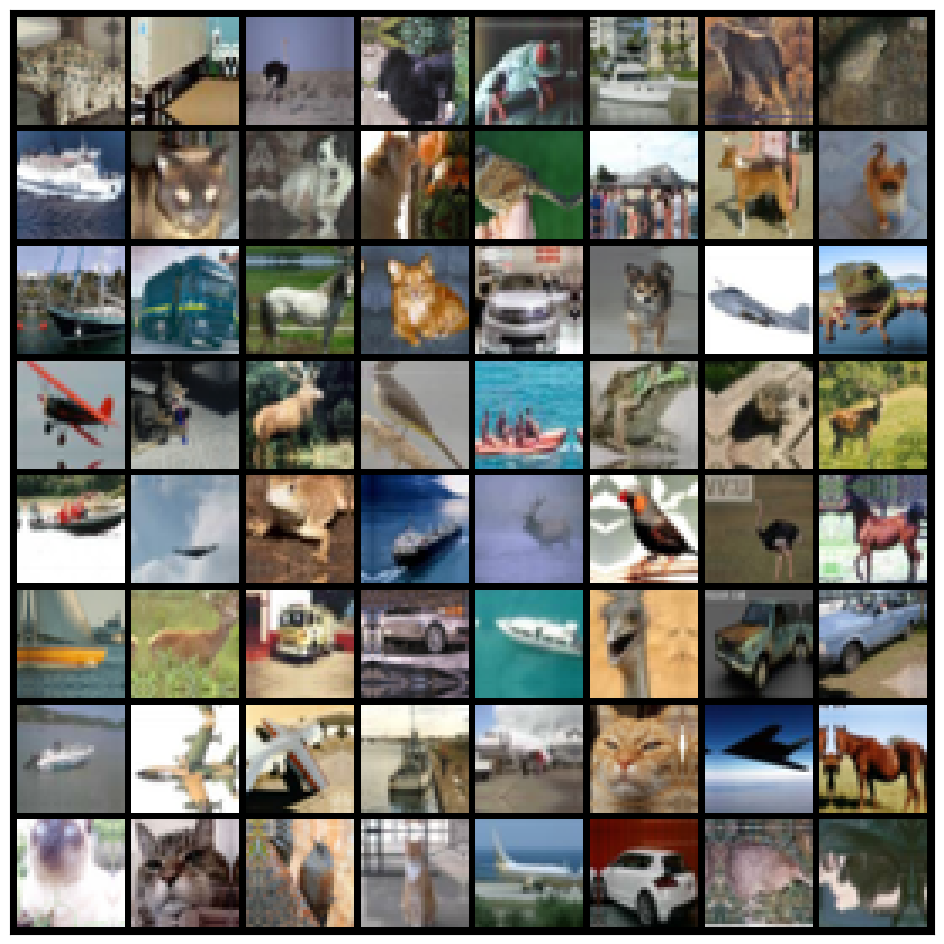

In [9]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [11]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which **adds the original input back to the output** (Augmentation?) feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

layers:

1. Convolutional Layer 1 (`self.conv1`)
2. Convolutional Layer 2 (`self.conv2`)

In [16]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [17]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [20]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a **learning rate scheduler, which will change the learning rate after every batch of training.** There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another **regularization technique** which prevents the weights from **becoming too large** by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

Gradient clipping is a technique commonly used during training in deep learning to prevent the exploding gradients problem. When the gradients of the loss function with respect to the model parameters become too large, it can lead to numerical instability during optimization, causing the model parameters to diverge or oscillate wildly. It helps stabilize the training process and improve convergence. The `nn.utils.clip_grad_value_()` function in PyTorch is commonly used for gradient clipping, allowing the gradients of model parameters to be clipped to a specified range.


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3015546798706055, 'val_acc': 0.10913462191820145}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the **Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training**. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [23]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5064, val_loss: 1.1456, val_acc: 0.5999
Epoch [1], last_lr: 0.00935, train_loss: 1.0805, val_loss: 1.7922, val_acc: 0.5160
Epoch [2], last_lr: 0.00972, train_loss: 0.8353, val_loss: 0.8877, val_acc: 0.7143
Epoch [3], last_lr: 0.00812, train_loss: 0.6337, val_loss: 0.6459, val_acc: 0.7788
Epoch [4], last_lr: 0.00556, train_loss: 0.5009, val_loss: 0.5697, val_acc: 0.8048
Epoch [5], last_lr: 0.00283, train_loss: 0.4022, val_loss: 0.4244, val_acc: 0.8607
Epoch [6], last_lr: 0.00077, train_loss: 0.2938, val_loss: 0.3046, val_acc: 0.8963
Epoch [7], last_lr: 0.00000, train_loss: 0.2208, val_loss: 0.2746, val_acc: 0.9108
CPU times: user 21.3 s, sys: 4.33 s, total: 25.6 s
Wall time: 4min 57s


In [25]:
train_time='4:57'

Our model trained to over **90% accuracy in under 5 minutes**! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:

1. 94% accuracy in under 10 minutes (easy)
2. 90% accuracy in under 2.5 minutes (intermediate)
3. 94% accuracy in under 5 minutes (hard)


Let's plot the valdation set accuracies to study how the model improves over time.

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

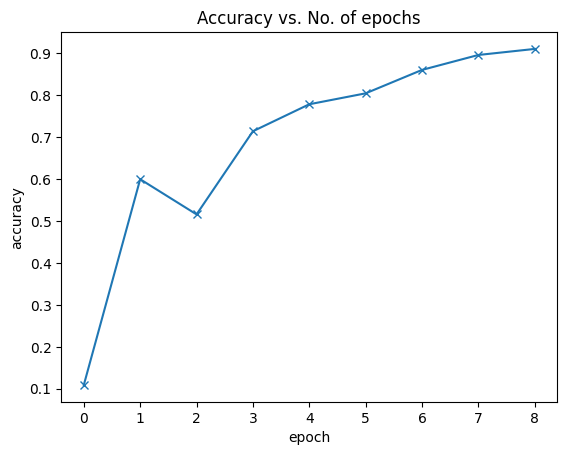

In [27]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

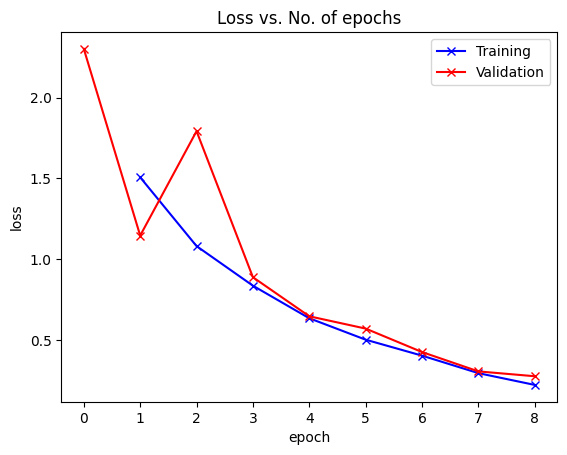

In [29]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet.

+ Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

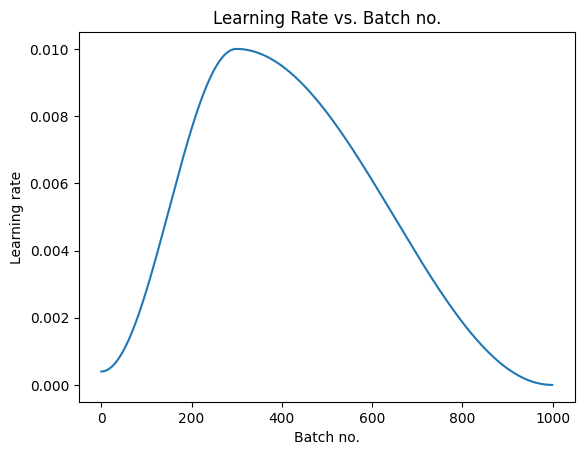

In [31]:
plot_lrs(history)

As expected, the **learning rate** starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

+ `clamp(0,1):` This operation is used to clip the pixel values of the image tensor between 0 and 1.

+ It ensures that the pixel values are within the valid range for displaying an image, which typically ranges from 0 (black) to 1 (white) for normalized images.

+ Values below 0 are set to 0, and values above 1 are set to 1.

In [33]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: ship


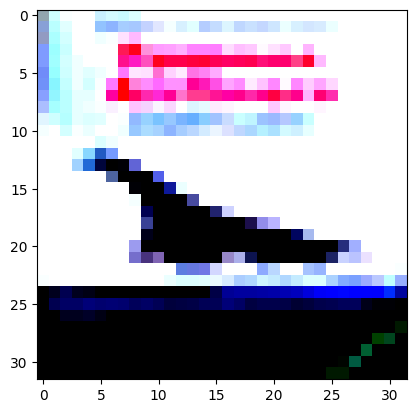

In [38]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


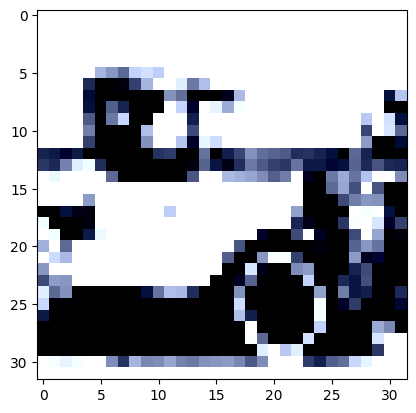

In [35]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


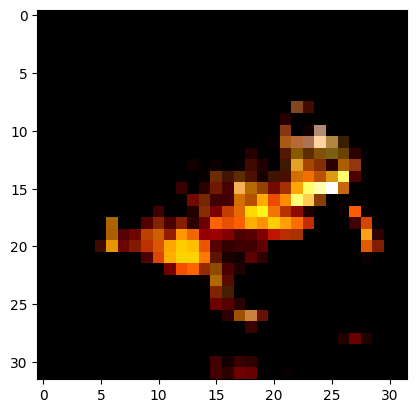

In [36]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))